In [2]:
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
except:
    print('NOT IPYTHON')

import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.widgets import Slider
from scipy.sparse import csc_matrix
import caiman as cm
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.initialization import greedyROI_corr
import matplotlib as mpl
import matplotlib.pyplot as plt
import bokeh
import bokeh.plotting as bpl
from bokeh.models import CustomJS, ColumnDataSource, Range1d
from bokeh.io import output_notebook, reset_output
import os 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def show_img(ax, img): 
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt 
    
    im = ax.imshow(img)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)

# step 1:  load data 

The dimension of data is  (1000, 128, 128)


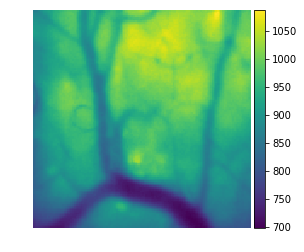

In [4]:
fname = './example_movies/data_endoscope.tif'
Y = cm.load(fname)
T, d1, d2 = Y.shape
print('The dimension of data is ',Y.shape)

ax = plt.axes()
ax.axis('off')
show_img(ax, Y[100,])

From the example above, we can see that 1-photon data typically have large and blurring background that contaminates the detection of neural signal. This makes it very hard to detect neurons and extract their temporal activities. CNMF-E uses spatially filtering to remove the low spatial frequency term and visualize neurons via two summary images: local correlation image and peak-to-noise ratios (PNR) image. Local correlation image highlights the locally correlated spatial structures, and PNR image highlights neurons' calcium transients. 

The spatial filtering that roughly removes the background is the key to the sucess of CNMF-E. The kernel is simply generated from a truncated Gaussian kernel. However, the important part is centering the kernel to make its mean equal to 0. 

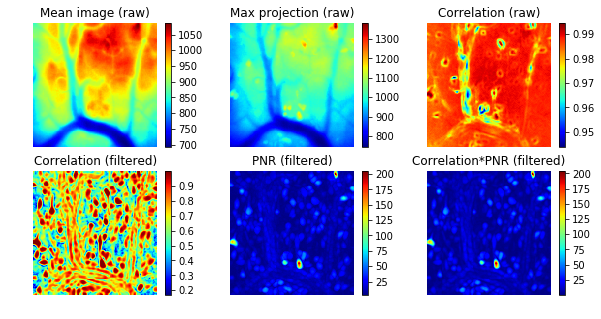

In [5]:
# parameters 
gSig = 3   # gaussian width of a 2D gaussian kernel, which approximates a neuron 
gSiz = 10  # average diameter of a neuron 
center_psf = True     # If True, the background can be roughly removed. This is useful when the background is strong. 

# show correlation image of the raw data; show correlation image and PNR image of the filtered data
cn_raw = cm.summary_images.local_correlations_fft(Y, swap_dim=False)
cn_filter, pnr = cm.summary_images.correlation_pnr(Y, gSig=gSig, center_psf=center_psf, swap_dim=False)
plt.figure(figsize=(10, 5))

for i, (data, title) in enumerate(((Y.mean(0), 'Mean image (raw)'),
                                   (Y.max(0), 'Max projection (raw)'),
                                   (cn_raw[1:-1,1:-1], 'Correlation (raw)'),
                                   (cn_filter, 'Correlation (filtered)'),
                                   (pnr, 'PNR (filtered)'),
                                   (cn_filter*pnr, 'Correlation*PNR (filtered)'))):
    plt.subplot(2,3,1+i)
    plt.imshow(data, cmap='jet', aspect='equal')
    plt.axis('off')
    plt.colorbar() 
    plt.title(title);

As we can see, the summary images resulted from the raw data poorly display isolated neurons. While spatial filtering significanly improves the visualization of single neurons. Our initialization procedure roots from this observation. We pick pixels with large local correlation coefficients and large PNR values, then we use them as seed pixels for initialization spatial & temporal components of all single neurons. 

To do initialization, we have to specify two thresholds for detecting seed pixels: the mininum local correlation and the minimum PNR. All pxiels satisfying these two requirements are chosen as our seed pixels. The initialization procedure stops when there are no seed pixels. 

When specifying the thresholds, we have to make sure most neurons have seed pixels above the thresholds. Otherwise, we may miss lots of neurons in this step. In the meanwhile, we want to make the thresholds to screen out most pixels that are out of neurons' ROIs. But don't be too picky about the parameter selection. CNMF-E can still pick neurons from the residual after we estimate the background and subtract it from the raw video in the later phase. 

# step 2: initialization 

<IPython.core.display.Javascript object>


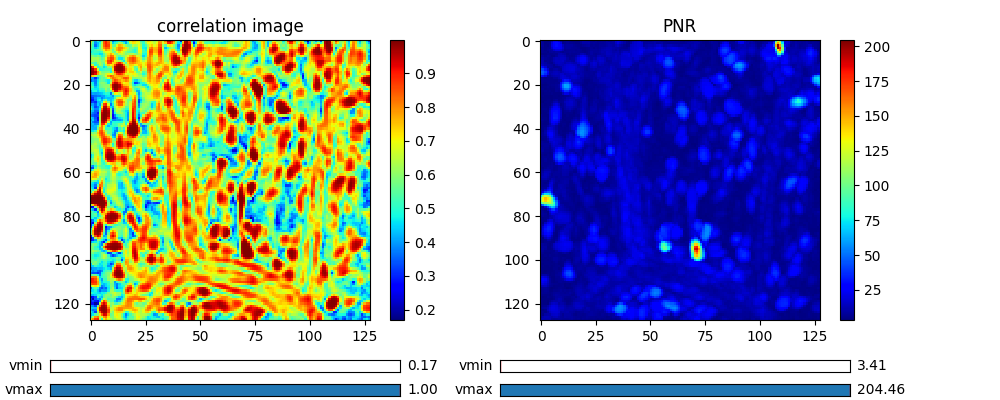

0

In [6]:
# pick thresholds 
%matplotlib notebook
fig = plt.figure(figsize=(10, 4))
plt.axes([0.05, 0.2, 0.4, 0.7])
im_cn = plt.imshow(cn_filter, cmap='jet')
plt.title('correlation image')
plt.colorbar()
plt.axes([0.5, 0.2, 0.4, 0.7])
im_pnr = plt.imshow(pnr, cmap='jet')
plt.title('PNR')
plt.colorbar();

s_cn_max = Slider(plt.axes([0.05, 0.01, 0.35, 0.03]), 'vmax', cn_filter.min(), cn_filter.max(), valinit=cn_filter.max())
s_cn_min = Slider(plt.axes([0.05, 0.07, 0.35, 0.03]), 'vmin', cn_filter.min(), cn_filter.max(), valinit=cn_filter.min())
s_pnr_max = Slider(plt.axes([0.5, 0.01, 0.35, 0.03]), 'vmax', pnr.min(), pnr.max(), valinit=pnr.max())
s_pnr_min = Slider(plt.axes([0.5, 0.07, 0.35, 0.03]), 'vmin', pnr.min(), pnr.max(), valinit=pnr.min())

def update(val):
    im_cn.set_clim([s_cn_min.val, s_cn_max.val])
    im_pnr.set_clim([s_pnr_min.val, s_pnr_max.val])
    fig.canvas.draw_idle()
s_cn_max.on_changed(update)
s_cn_min.on_changed(update)
s_pnr_max.on_changed(update)
s_pnr_min.on_changed(update)
# 'min_corr=0.85', 'min_pnr=20'

0 neurons have been initialized
10 neurons have been initialized
20 neurons have been initialized
30 neurons have been initialized
40 neurons have been initialized
50 neurons have been initialized
60 neurons have been initialized
70 neurons have been initialized
80 neurons have been initialized
90 neurons have been initialized
100 neurons have been initialized
In total,  102 neurons were initialized.


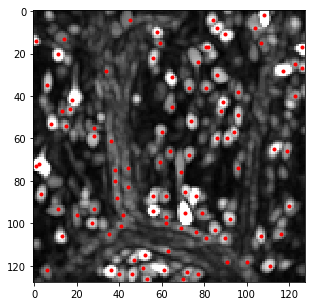

In [7]:
%matplotlib inline
min_corr = 0.9
min_pnr = 20
min_pixel = 5**2    # minimum number of nonzero pixels
save_video = True 
if not os.path.exists('tmp'): 
    os.mkdir('tmp')
video_name = os.path.join('tmp', 'initialization.mp4')
from caiman.source_extraction.cnmf.initialization import init_neurons_corr_pnr
A, C, C_raw, S, center =  init_neurons_corr_pnr(Y, gSiz=gSiz, gSig=gSig,
                   center_psf=True, min_corr=min_corr, min_pnr=min_pnr, swap_dim = False, save_video = save_video,
                                                video_name = video_name, min_pixel=3)
plt.figure(figsize=(5,5))
plt.imshow(cn_filter*pnr, vmax=40, cmap='gray')
plt.plot(center[0], center[1], '.r')

If you set save_video as True, then you are supposed to find a video  named 'initialization.mp4' in your current working folder. It desplays the whole procedure of the initialization. 

Here we set the thresholds that are very high to only pick neurons with high qualities. We can still see some weak neurons that are not picked up. In the following steps, we are going to estimate the background first and then pick more neurons from the residual (Y-A*C-B) video. 

# step 3: estimating the background 

# TO BE TESTED 

In [ ]:
# INIT no patches
cnm = cnmf.CNMF(2, method_init='corr_pnr', k=None, gSig=(3,3), merge_thresh=.8,
                p=1, dview=None, tsub=1, ssub=1, Ain=None, gnb=10, method_deconvolution='oasis', 
                low_rank_background=False, update_background_components=False)

In [ ]:
# INIT patches
cnm = cnmf.CNMF(2, method_init='corr_pnr', k=None, gSig=(3,3), merge_thresh=.8,
                p=1, dview=None, tsub=1, ssub=1, Ain=None, rf=(20,20), stride=(10,10),
                only_init_patch=True, gnb=10, nb_patch=3, method_deconvolution='oasis', 
                low_rank_background=False, update_background_components=False)

In [ ]:
cnm.options['init_params']['gSiz'] = (10, 10)
cnm.options['init_params']['gSig'] = (3, 3)
cnm.options['init_params']['min_corr'] = .85
cnm.options['init_params']['min_pnr'] = 20
cnm.options['init_params']['normalize_init']=False

# Step 3: run CNMF

In [ ]:
memmap = True  # must be True for patches
if memmap:
    fname_new = cm.save_memmap([fname], base_name='Yr')
    Yr, dims, T = cm.load_memmap(fname_new)
    cnm.fit(Yr.T.reshape((T,) + dims, order='F'))
else:
    cnm.fit(Y)

# Step 4: Visualize results


In [ ]:
output_notebook()  # create output within this notebook
# reset_output()  # default creates output in seperate html file
if memmap:
    traces_fluo = cm.utils.visualization.nb_view_patches(Yr, cnm.A, cnm.C, cnm.b, cnm.f, 
                                                         dims[0],dims[1], denoised_color='red',
                                                         image_neurons=cn_filter)
else:
    traces_fluo = cm.utils.visualization.nb_view_patches(Y.reshape(len(Y),-1,order='F').T, cnm.A, cnm.C, cnm.b, cnm.f,
                                                         Y.shape[1], Y.shape[2], denoised_color='red',
                                                         image_neurons=cn_filter, thr=.9)

In [ ]:
def nb_view_background(b, f, dims):
    bokeh.io.curdoc().clear()
    d1,d2=dims
    nb = np.linalg.norm(b,2,0)
    b = b/nb
    f = f * nb[:,None]
    nr, T = f.shape
    # split sources up, such that Bokeh does not warn
    # "ColumnDataSource's columns must be of the same length"
    source = ColumnDataSource(data=dict(x=np.arange(T), y=f[0]/100))
    source_ = ColumnDataSource(data=dict(z=f/100))
    nb = np.linalg.norm(b,2,0)
    source3 = ColumnDataSource(
                data=dict(image=[b[:,0].reshape(dims, order='F')[::-1]],
                          im=[b.T.reshape((-1,)+dims, order='F')[:,::-1]],
                          x=[0], y=[d2], dw=[d1], dh=[d2]))

    callback = CustomJS(args=dict(source=source, source_=source_, source3=source3), code="""
            var data = source.get('data')
            var data_ = source_.get('data')
            var f = cb_obj.get('value')-1
            x = data['x']
            y = data['y']
            for (i = 0; i < x.length; i++) {
                y[i] = data_['z'][i+f*x.length]
            }

            var dh = source3.data['dh'][0];
            var dw = source3.data['dw'][0];
            var image = source3.data['image'][0];
            var images = source3.data['im'][0];
            for (var i = 0; i < x.length; i++) {
                for (var j = 0; j < dw; j++){
                    image[i*dh+j] = images[f*dh*dw + i*dh + j];
                }
            }

            source3.trigger('change')
            source.trigger('change')
        """)

    plot = bpl.figure(plot_width=600, plot_height=300)
    plot.line('x', 'y', source=source, line_width=1, line_alpha=0.6)

    slider = bokeh.models.Slider(start=1, end=f.shape[0], value=1, step=1,
                                 title="Neuron Number", callback=callback)

    xr = Range1d(start=0, end=d1)
    yr = Range1d(start=d2, end=0)
    plot1 = bpl.figure(x_range=xr, y_range=yr, plot_width=300, plot_height=300)
    colormap = mpl.cm.get_cmap('jet')
    cmap = bokeh.models.mappers.LinearColorMapper([mpl.colors.rgb2hex(m)
                                                   for m in colormap(np.arange(colormap.N))])
    cmap.high = b.max()
    plot1.image(image='image', x='x', y='y', dw='dw', dh='dh',
                        color_mapper=cmap, source=source3)

    bpl.show(bokeh.layouts.layout([[slider], [bokeh.layouts.row(plot1, plot)]]))


In [ ]:
nb_view_background(cnm.b, cnm.f, dims)